In [99]:
import matplotlib.pyplot as plt
import math
import skimage
import cv2
import numpy as np
import copy
import skimage.metrics as metric
from scipy import signal
from skimage.measure import block_reduce
from os import listdir
from os.path import isfile, join
import random
from skimage.util import view_as_windows
print("Imports done")

Imports done


In [100]:
# random functions that are used all over the project
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def loadImageGray(name):
    return cv2.imread(name,0)

def affichage_rows_cols_images(rows, cols, images, labels):
    rows = rows
    cols = cols
    axes = []
    fig = plt.figure(figsize=(6*rows,4*cols))
    for i in range(rows * cols):
        axes.append(fig.add_subplot(rows, cols, i + 1))
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def creatUniformMatrix(low, high, h, w):
    m = np.int_(np.floor(np.random.uniform(low,high,h*w)*2))
    return np.where(m == 0, -1, m)

def sampleAmount(n1,n2,d):
    return int((n1*n2)*d)
    
def takeSample(w_, n):
    done = []
    w = np.int_(np.zeros(w_.shape))
    while n > 0:
        r = np.random.randint(0, w_.shape[0])
        if r not in done:
            w[r] = w_[r]
            n = n - 1
            done.append(r)
    return w

def applayWatermakr(x,w):
    return np.clip(x + w, 0, 255)

def gaussianNoise(n, m , mu, sigma):
    return np.asarray([[np.random.normal(mu,sigma) for i in range(m)] for j in range(n)])

def MSE(X,Y):
    if X.shape == Y.shape:
        return np.sum([np.sum([(X[j,i]- Y[j,i])**2 for i in range(X.shape[1])]) for j in range(X.shape[0])]) / (X.shape[0]*X.shape[1])
    else:
        return 0

def PSNR(X,Y):
    a = 255
    mse = MSE(X,Y)
    if mse != 0:
        return 10 * np.log10(a**2/mse)
    else:
        return 0
        
def computeLinearCorr(x,y):
    m,n = x.shape
    s = 0
    c = 0
    for i in range(m):
        for j in range(n):
            if x[i,j] != 0:
                s = s + x[i,j]*y[i,j]
                c = c + 1
    return s/c

def convolution(x,w_size):
    res = np.copy(x)
    height,width = x.shape
    margin = int((w_size-1)/2)
    for i in range(margin,height-margin):
        for j in range(margin,width-margin):
            res[i,j] = np.int64(np.mean(x[i-margin:i+margin+1, j-margin: j+margin+1]))
    return res

### 1 - watermark embedding and channel modeling

In [101]:
x = loadImageGray("liftingbody.png")
height,width = x.shape
print("image height : ", height)
print("image width : ", width)
w_p = creatUniformMatrix(0, 1, height, width)
print(w_p.shape)
density = 0.5
watermarkLength = sampleAmount(height,width,density)
watermark = takeSample(w_p, watermarkLength).reshape(height, width)
print(x.shape)
print(x.shape)

image height :  512
image width :  512
(262144,)
(512, 512)
(512, 512)


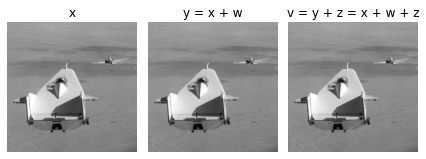

PSNR x and y  51.141799435894136
PSNR y and v  48.14778669609568
PSNR x and v  46.37673733271882


In [102]:
y = applayWatermakr(x, watermark)
z = gaussianNoise(height,width, 0,1)
v = applayWatermakr(y,z)
affichage_rows_cols_images(1, 3, [x,y,v], ["x","y = x + w","v = y + z = x + w + z"])
print("PSNR x and y ", PSNR(x,y))
print("PSNR y and v ", PSNR(y,v))
print("PSNR x and v ", PSNR(x,v))

Neither Y nor V change enough to see/notice differences between the three images

### 2 - Non-blind watermark detection

In [103]:
w_nonBlind = v-x
linearCorr_nonBlind = computeLinearCorr(watermark, w_nonBlind)
print(linearCorr_nonBlind)


1.0013691241394567


### 3 - Blind watermark detection using the Maximum Likelihood estimate

In [104]:
# window will be 3 by 3 
v_ = convolution(v,3)

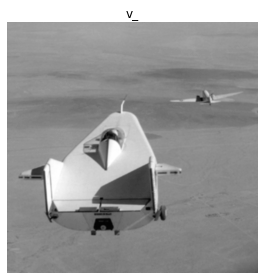

PSNR x and v  46.37673733271882
PSNR x and v_  36.62903198774871


In [105]:
affichage_rows_cols_images(1, 1, [v_], ["v_"])
print("PSNR x and v ", PSNR(x,v))
print("PSNR x and v_ ", PSNR(v_,x))

In [106]:
w_blind = v - v_
linearCorr_blind = computeLinearCorr(watermark, w_blind)
print(linearCorr_blind)

0.8760021867532067


### THEORY (EXPLANATION AND ANSWERS TO QUESTIONS)

We start with an original image X  
We compute a watermark at random locations of X that is either +1 or -1 to the given pixel  
The watermark is of length N, here N = n * m * 0.5, n and m being the dimensions of x  
We compute y = x + w (simple pixel wize addition)  
  
Now we compute matrix z that represents some noise, this noise is an additive white gaussian noise N(0,1).  
z represents a possible attack on our image, that tries to remove our watermark  
This attack is done by adding the computed random noise to the image: v = y + z  
  
Now the goal is to detect the watermark from v = y + z = x + w + z  
there are 2 ways of doing this:  
  
(1) the first one is the "simple" and non practical, that requires us having access to the original image x  
we compute w_nonBlind = v - x = x + w + z -x = w + z => w_nonBlind = w + z  
now we compute the linear correlation between w and w_nonBlind, w is known to us because we have the key  
We only consider the bits where w != 0 => this is our advantage as a defender, we know where the watermark modified the image x  
now because we had access to x, this result is very high => ~0.996 (very close to 1)   
with this correlation, one can safily say that the watermark is present  
  
(2) in here we have no knowledge of the original image x  
instead we make a guess of what it is by computing a local mean (a convolution)  
this operation basically removes edges from our signal  
v_ = convolution(v)  
now we compute w_blind = v - v_  
finally, just like before, we compute the linear correlation between w_blind and w  
since v_ is only a good approximation of x, but still different from x, we get => ~0.870 (still close to 1)  
it is still a very good result, the advantage we have as a deffender, is the same as before, because we know where w modified x, we know where to look  

### GOING FURTHER

In [107]:
v_no_w = x + z
v_no_w_conv = convolution(v_no_w,3)
w_blind_no_w = v_no_w_conv - v_no_w
linearCorr_blind_no_w = computeLinearCorr(watermark, w_blind_no_w)
print(linearCorr_blind_no_w)

0.0062961388146826535


I went a bit further, and computed v_no_w = x + z  
and tried to do the same as in the way (2)  
I computed the convolution of v_no_w  
and extracted the estimated watermark  
once I computed the linear correlation between the w and its estimation, I found => ~0.0108 (close to 0)   
Which is a very good result, we can safily say that the watermark isn't present !  